# Generative models - auto-encoders

### Author: Philippe Esling (esling@ircam.fr)

In this course we will cover
1. A brief introduction to [generative models](#generative)
2. A formal presentation of [Auto-Encoders](#ae) (AEs)
3. An explanation of how to [implement AEs](#implement)
4. An [application](#application) of AEs for modeling images
4. An practical exemple of [convolutional denoising AEs](#denoising) for image data **(exercise)**

<a id="generative"></a>

## Generative models

### Supervised refresher

Until now, we have mostly discussed models that are developed for _supervised_ and _discriminative_ tasks. To formalize this problem, we have a set of data $\{\mathbf{x}_{i}, \mathbf{y}_{i}\}_{i\in[1,n]}$, where the $\mathbf{x}_{i}$ and $\mathbf{y}_{i}$ are linked. Therefore, we want to approximate this relation through
\begin{equation}
    \mathbf{\hat{y}} = \mathcal{F}_\mathbf{\theta}(\mathbf{x})  
\end{equation}
where we train the parameters $\mathbf{\theta}$ so that $\mathbf{\hat{y}}\approx\mathbf{y}$. The existence of a label $\mathbf{y}$ ("correct answer") defines a _supervised_ problem

### Going unsupervised

In some cases, we might only have a set of data $\{\mathbf{x}_{i}\}_{i\in[1,n]}$, and still be interested in learning some underlying properties or structure of this set. In that case, the problem is _unsupervised_ as we have to learn without a given answer. 

Here, we can turn to _generative_ models [[1](#reference1)], which allows to create new data instances based on the observation of existing examples. Although these models are more naturally defined in a _probabilistic way_, we will assume that we have some simple _code_ $\mathbf{z}$, which allows to control the properties of the generation, and need to learn
\begin{equation}
    \mathbf{\hat{x}} = \mathcal{F}_\mathbf{\theta}(\mathbf{z})  
\end{equation}
where we still need to learn $\mathbf{\theta}$, so that $\mathbf{\hat{x}}$ have similar properties to that of the examples in $\{\mathbf{x}_{i}\}_{i\in[1,n]}$.

Now the problem to solve is how we can learn directly from a set of data.

<a id="ae"></a>

## Auto-encoders

One way to understand a set of data is to try to _compress_, or _simplify_ the corresponding dataset. So the idea is to learn simultaneously how to _encode_ our unlabeled input $\{\mathbf{x}_{i}\}_{i\in[1,n]}$ and to _decode_ the corresponding representation. This idea give rise to the notion of **auto-encoder**. 

### Architecture 

The auto-encoder is an unsupervised architecture originally proposed to perform _dimensionality reduction_ [[3](#reference3)]. As its name indicates, we will try to train this model to learn an efficient _encoding_ $\mathbf{z}$ of unlabeled input data $\mathbf{x}$. The only way to learn efficient parameters is to also learn a _decoding_ function to _reconstruct_ $\mathbf{x}$ from $\mathbf{z}$.

<img src="images/auto_encoder.png"/>

As shown here, a first model $\mathcal{E}_\phi$ \textit{encodes} the input into a \textit{latent code} $\mathbf{z}$ in order to provide a low-dimensional representation of the data. A second model $\mathcal{D}_\theta$ designated as the \textit{decoder} aims to generate outputs from $\mathbf{z}$ that are as close to the original inputs as possible.

### Formal definition

The latent code $\mathbf{z}$ can be seen as a compressed abstract representation, and may be used as an intermediate space for analysis or generation. This helps to govern the distribution of the data through a simpler and higher-level representation, while enhancing the \textit{expressiveness} of the generative model.
The behaviour of an auto-encoder can be formalized as:
\begin{align}
    \mathbf{z} &= \mathcal{E}_\phi(\mathbf{x}) \\
    \mathbf{\hat{x}} &= \mathcal{D}_\theta(\mathbf{z})  
\end{align}
with the \textit{encoder} $\mathcal{E}_\phi$ and \textit{decoder} $\mathcal{D}_\theta$ functions parameterized respectively by $\phi$ and $\theta$. As we can see this defines the reconstruction relationship
\begin{equation}
    \mathbf{\hat{x}} = \mathcal{D}_\theta(\mathcal{E}_\phi(\mathbf{x}))  
\end{equation}

### Training

The training of an auto-encoder consists in finding the optimal functions of encoding $\mathcal{E}^*$ and decoding $\mathcal{D}^*$ by evaluating the \textit{reconstruction error} $\mathcal{L}$ between $\mathbf{x}$ and $\mathbf{\hat{x}}$, such that
\begin{equation}
    \mathcal{E}^*, \mathcal{D}^* = arg\,min_{ \phi, \theta}{\mathcal{L}}(\mathbf{x}, \mathcal{D}_\theta(\mathcal{E}_\phi(\mathbf{x})))
\end{equation}

As the latent space usually has a smaller dimensionality than the input, it acts as an incentive for the network to find the main attributes of variations in the dataset (and also explains its use for _dimensionality reduction_).

### Variants and discussion

There are several variants of auto-encoders, such as denoising auto-encoders or variational auto-encoders. Each address some downside of the basic AE model. For instance, the deterministic nature of the basic auto-encoder implies a point-wise mapping of the latent space, meaning that not all the latent positions can be leveraged to produce relevant reconstructions. Because of this reason, there is no way to ensure that the latent space could allow a robust generalization and that any random $\mathbf{z}$ would generate a meaningful output.

<a id="implement"> </a>

## Implementation

Here, we discuss how we can implement and train a simple auto-encoder network in _TensorFlow_. As discussed earlier, an AE is composed of two parts, an **encoder** and a **decoder**. The goal of the encoder is to "compress" the dataset, representing its principal features with a very small code, while the goal of the decoder is to learn how to reproduce the initial input from this code. Hence, we will first need to use some basic imports and definition to setup our problem

### Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

### Load the dataset

To start with a pragmatic and simple to understand example, we  will try to train the basic AE using the Fashon MNIST dataset. This dataset contains images of size 28x28 pixels, with different pieces of clothing. The following code allows to load (and eventually download) the dataset, by using the `tensorflow.keras.datasets` module. We also plot some randomly selected test examples

Number of training examples
(60000, 28, 28)
Number of testing examples
(10000, 28, 28)


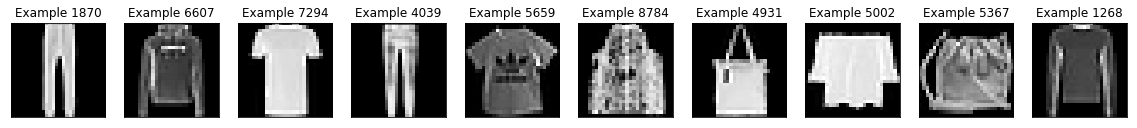

In [2]:
# Load (and eventually download) the dataset
(x_train, _), (x_test, _) = fashion_mnist.load_data()
# Normalize the dataset in the [0, 1] range]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
print('Number of training examples')
print (x_train.shape)
print('Number of testing examples')
print (x_test.shape)
plt.figure(figsize=(20, 4))
# Plot some randomly selected input
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    i_val = np.random.randint(x_test.shape[0])
    plt.imshow(x_test[i_val])
    plt.gray()
    plt.title("Example %d"%(i_val))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Basic auto-encoder

We recall here that in order to define an autoencoder, we will need an `encoder`, which compresses the images into a small latent vector, and a `decoder`, that reconstructs the original image from this code. Here, we will start very basic and define the encoder and decoder as simple `Dense` layers. To define the model simply, we will use the [Keras API](https://www.tensorflow.org/guide/keras/custom_layers_and_models) defined in the `tensorflow.keras` module (Note that we pre-loaded the `layers` submodule

In [3]:
class AE(Model):
    def __init__(self, encoding_dim):
        super(AE, self).__init__()
        self.latent_dim = encoding_dim   
        self.encoder = tf.keras.Sequential([
          layers.Flatten(),
          layers.Dense(self.latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(784, activation='sigmoid'),
          layers.Reshape((28, 28))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Here we can see that the model depends on a given `encoding_dim` variable, which defines the size of the latent code. Therefore, we can instantiate our model arbitrarliy with `64` dimensions

In [4]:
latent_dim = 64   
autoencoder = AE(latent_dim) 

The only remaining part that we did not discuss yet is what type of _loss_ (defined as $\mathcal{L}$) we can use to train our model. First, we will simply rely on the _Mean Squared Error_ (MSE) loss, which is defined as
\begin{equation}
    \mathcal{L}_{MSE}(\hat{\mathbf{x}}, \mathbf{x}) = \mid \hat{\mathbf{x}}, \mathbf{x} \mid^{2}
\end{equation}

In [6]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

<a id="application"> </a>

### Training the model

Train the model using `x_train` as both the input and the target. The `encoder` will learn to compress the dataset from 784 dimensions to the latent space, and the `decoder` will learn to reconstruct the original images.
.

In [9]:
autoencoder.fit(x_train, x_train, epochs=10, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 2s 992us/step - loss: 0.0086 - val_loss: 0.0088
Epoch 2/10
1875/1875 [==============================] - 2s 966us/step - loss: 0.0086 - val_loss: 0.0088
Epoch 3/10
1875/1875 [==============================] - 2s 983us/step - loss: 0.0086 - val_loss: 0.0087
Epoch 4/10
1875/1875 [==============================] - 2s 993us/step - loss: 0.0086 - val_loss: 0.0087
Epoch 5/10
1875/1875 [==============================] - 2s 978us/step - loss: 0.0086 - val_loss: 0.0088
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0086 - val_loss: 0.0088
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0086 - val_loss: 0.0087
Epoch 8/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0086 - val_loss: 0.0087
Epoch 9/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0086 - val_loss: 0.0087
Epoch 10/10
1875/1875 [==============================] - 2s 1ms/step - l

Now that the model is trained, we can test it by encoding and decoding images from the test set.

In [15]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

By plotting the images, we can see that the model is able to perform an adequate (yet somewhat blurry) reconstruction of the input images. The interesting point is that this reconstruction comes from a code of only `64` dimensions, whereas the original images have `784` dimensions.

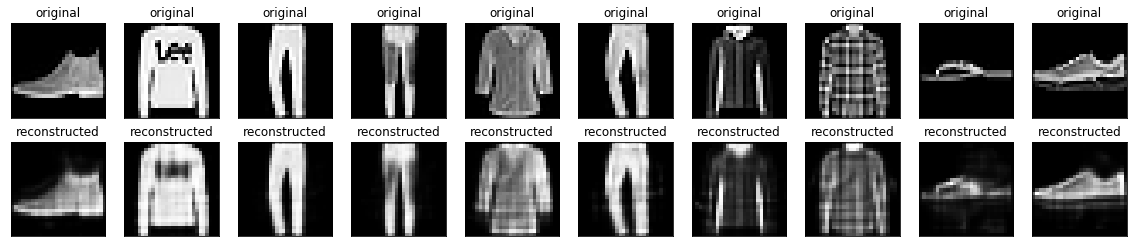

In [16]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

### Improvements

Even though this very basic example seems to work, several improvements can be made over the original model. First, we can see that the overall framework does not depend on the exact nature of the `encoder` and `decoder`. Therefore, we can rewrite the original class to accept any type of architecture for these (see code below). Another aspect that has a major impact on the results is the type of `loss` used. The `MeanSquaredError` tend to favor blurry reconstructions, and could be replaced by a `Multinoulli` loss. You can experiment with these ideas below.

In [18]:
class AE(Model):
  def __init__(self, encoder, decoder, encoding_dim):
    super(AE, self).__init__()
    self.latent_dim = encoding_dim
    self.encoder = encoder
    self.decoder = decoder

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

## Exercise: Denoising AE

Imagine (for the sake of argument), that we choose an encoding dimension which is of same dimensionality as the input one. Then, one huge problem is that nothing prevents the AE from simply learning the _identity_ function (try to imagine why). An autoencoder can also be trained to remove noise from images. This type of _regularization_ prevents the model from learning this degenerate situation.

In this exercise, you will need to create your own denoising AE, by relying on a noisy version of the Fashion MNIST dataset (adding random Gaussian noise to each image). You will then train an autoencoder using the noisy image as input, and the original image as the target.

Let's reimport the dataset to omit the modifications made earlier.

In [29]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
print(x_train.shape)

(60000, 28, 28)


Here, we create two new train and test sets by adding random noise to the images

In [30]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 
x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

Plot the noisy images.


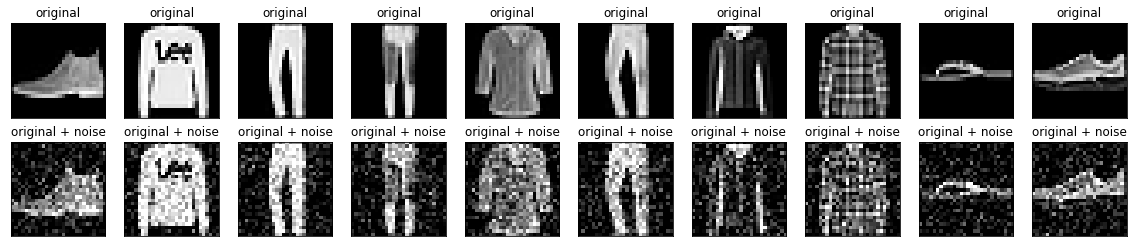

In [31]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(x_test[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.gray()
    ax = plt.subplot(2, n, i + 1 + n)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.gray()
plt.show()

### Define a convolutional autoencoder

In this example, you will train a convolutional autoencoder using  [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layers in the `encoder`, and [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) layers in the `decoder`.

In [19]:
class DenoisingAE(AE):
  def __init__(self):
    super(DenoisingAE, self).__init__()
    self.encoder = ...    
    self.decoder = ...
    
  def call(self, x):
    encoded = ...
    decoded = ...
    return decoded

autoencoder = ...

Compile and fit your model with appropriate losses

In [ ]:
autoencoder.compile(...)
autoencoder.fit(...)

Let's take a look at a summary of the encoder and decoder. Notice how the images are downsampled and then upsampled back to the original input size.

In [ ]:
autoencoder.encoder.summary()
autoencoder.decoder.summary()

Plot both the noisy images and the denoised images produced by the autoencoder to check that your implementation is correct

In [32]:
encoded_imgs = ...
decoded_imgs = ...
plt.figure(figsize=(20, 4))
for i in range(n):
    ...
plt.show()

<Figure size 1440x288 with 0 Axes>

### References

<a id="reference1"></a>
[1] Rezende, Danilo Jimenez, and Shakir Mohamed. "Variational inference with normalizing flows." _arXiv preprint arXiv:1505.05770_ (2015). [link](http://arxiv.org/pdf/1505.05770)

[2] Kingma, Diederik P., Tim Salimans, and Max Welling. "Improving Variational Inference with Inverse Autoregressive Flow." _arXiv preprint arXiv:1606.04934_ (2016). [link](https://arxiv.org/abs/1606.04934)

[3] Kingma, D. P., & Welling, M. Auto-encoding variational bayes. arXiv preprint arXiv:1312.6114. (2013). [link](https://arxiv.org/pdf/1312.6114)

[4] Rezende, D. J., Mohamed, S., & Wierstra, D. Stochastic backpropagation and approximate inference in deep generative models. arXiv preprint arXiv:1401.4082. (2014). [link](https://arxiv.org/pdf/1401.4082)

[5] Gulrajani, I., Kumar, K., Ahmed, F., Taiga, A. A., Visin, F., Vazquez, D., & Courville, A. (2016). Pixelvae: A latent variable model for natural images. arXiv preprint arXiv:1611.05013. [link](https://arxiv.org/pdf/1611.05013)

[6] Van den Oord, A., & Vinyals, O. (2017). Neural discrete representation learning. In NIPS 2017 (pp. 6306-6315). [link](http://papers.nips.cc/paper/7210-neural-discrete-representation-learning.pdf)